### Semantic Analysis

In [60]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import numpy as np

from google import genai
from google.genai.types import EmbedContentConfig

from scipy.spatial import ConvexHull


In [61]:
#import dataset
df = pd.read_csv("../output/llm_df.csv")

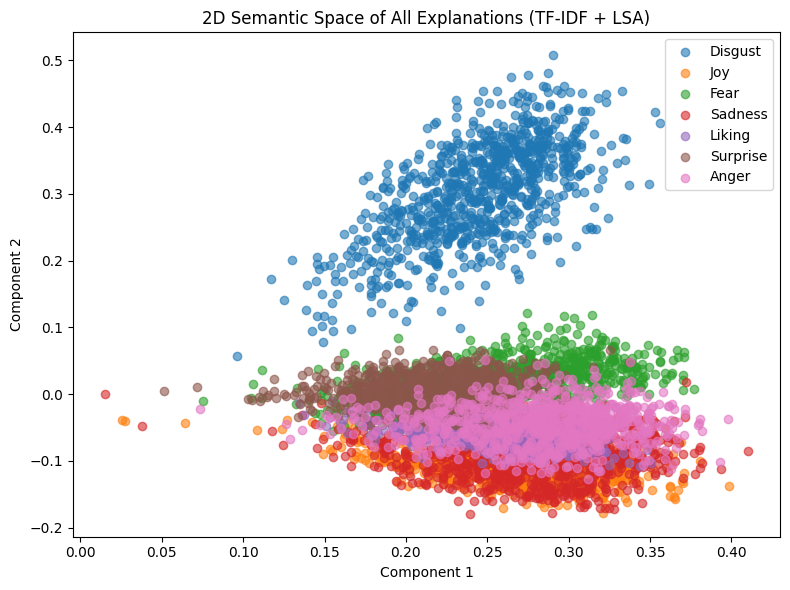

In [12]:

# 1. Load the data
texts = df['emo_explanation'].fillna('').tolist()
emotions = df['Emotion'].tolist()

# 2. Vectorize all explanations with TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(texts)

# 3. Reduce to 2D via Truncated SVD (LSA)
svd = TruncatedSVD(n_components=2, random_state=0)
X2 = svd.fit_transform(X)

# 4. Plot the semantic space
plt.figure(figsize=(8,6))
unique_emotions = list(dict.fromkeys(emotions))  # preserve order
for emo in unique_emotions:
    mask = np.array(emotions) == emo
    plt.scatter(X2[mask, 0], X2[mask, 1], label=emo, alpha=0.6)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('2D Semantic Space of All Explanations (TF-IDF + LSA)')
plt.legend()
plt.tight_layout()
plt.show()


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=3000,
    ngram_range=(1,3)
)
X = vectorizer.fit_transform(df['emo_explanation'].fillna(''))


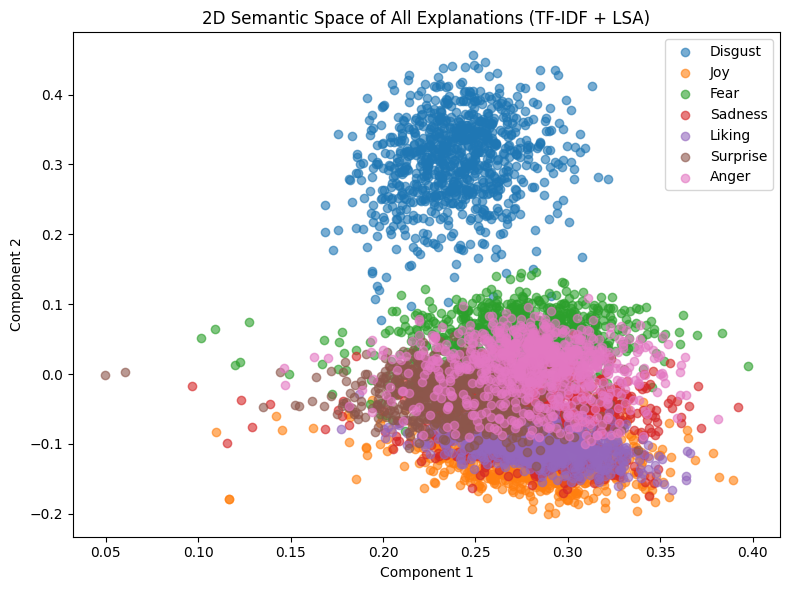

In [ ]:

svd = TruncatedSVD(n_components=2, random_state=0)
X2 = svd.fit_transform(X)

# 4. Plot the semantic space
plt.figure(figsize=(8,6))
unique_emotions = list(dict.fromkeys(emotions))  
for emo in unique_emotions:
    mask = np.array(emotions) == emo
    plt.scatter(X2[mask, 0], X2[mask, 1], label=emo, alpha=0.6)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('2D Semantic Space of All Explanations (TF-IDF + LSA)')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:

summaries = []
for emo in df['Emotion'].unique():
    mask = df['Emotion'] == emo
    coords = X2[mask]  # or X2_umap
    centroid = coords.mean(axis=0)
    hull = ConvexHull(coords)
    summaries.append({
        'Emotion': emo,
        'Centroid_X': centroid[0],
        'Centroid_Y': centroid[1],
        'Hull_Area': hull.volume
    })
summary_df = pd.DataFrame(summaries)

In [45]:
summary_df

,Emotion,Centroid_X,Centroid_Y,Hull_Area
0,Disgust,0.239776,0.305350,0.045528
1,Joy,0.281189,-0.117211,0.039387
2,Fear,0.271777,0.045940,0.042903
3,Sadness,0.283325,-0.065735,0.046415
4,Liking,0.283835,-0.102522,0.016219
5,Surprise,0.241707,-0.029851,0.032762
6,Anger,0.281590,0.008433,0.033839


In [34]:
import pandas as pd
from google import genai
from google.genai.types import EmbedContentConfig
from tqdm import tqdm

# 1. Init Vertex-backed GenAI client
client = genai.Client(
    vertexai=True,
    project="emotion-art-analysis",
    location="us-central1",
)

# 2. Load your LLM explanations

texts = df['emo_explanation'].fillna('').tolist()

# 3. Embed one at a time (batchSize must be 1)
embeddings = []
for text in tqdm(texts, desc="Embedding explanations"):
    resp = client.models.embed_content(
        model="gemini-embedding-001",
        contents=[text],  # single-item list
        config=EmbedContentConfig(
            task_type="CLUSTERING",

        ),
    )
    # grab the single embedding vector
    embeddings.append(resp.embeddings[0].values)

# 4. Attach embeddings and save
df['embedding'] = embeddings


Embedding explanations: 100%|██████████| 6076/6076 [12:40<00:00,  7.99it/s]


OSError: Cannot save file into a non-existent directory: '/mnt/data'

In [35]:

df.to_parquet('../output/llm__embeddings.parquet', index=False)

print("✓ All explanations embedded and saved to llm_df_with_embeddings.parquet")


✓ All explanations embedded and saved to llm_df_with_embeddings.parquet


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Force single-threaded BLAS (avoids threadpool errors)
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"]     = "1"
os.environ["MKL_NUM_THREADS"]     = "1"

# 1. Load your DataFrame with embeddings
embedding_df = pd.read_parquet('../output/llm__embeddings.parquet')

# 2. Convert list-of-lists into a 2D NumPy array
embeddings = np.array(embedding_df['embedding'].tolist())

# 3. Silhouette analysis to pick k (clusters = 2…8)
sil_scores = {}
for k in range(2, 9):
    clust = AgglomerativeClustering(n_clusters=k)
    labels = clust.fit_predict(embeddings)
    sil_scores[k] = silhouette_score(embeddings, labels)

print("Silhouette scores:", sil_scores)

# 4. Choose best k and fit final clustering
best_k = max(sil_scores, key=sil_scores.get)
print(f"→ Best k by silhouette: {best_k}")
embedding_df['cluster'] = AgglomerativeClustering(n_clusters=best_k).fit_predict(embeddings)



Silhouette scores: {2: 0.19175127229295452, 3: 0.1328570865478126, 4: 0.16440356945556492, 5: 0.17751374158951477, 6: 0.19921659209045514, 7: 0.20770649862373225, 8: 0.19556757651995554}
→ Best k by silhouette: 7


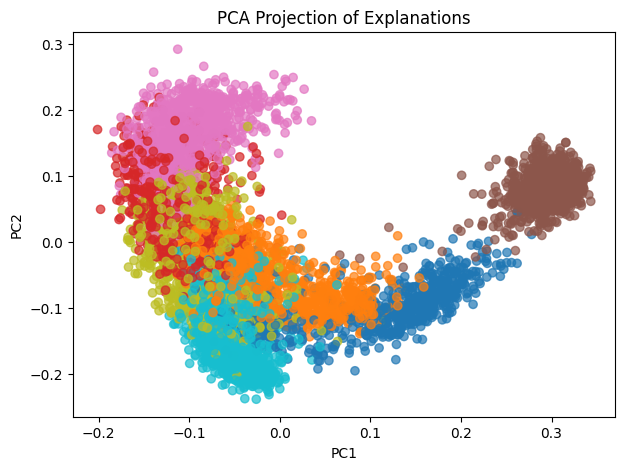

In [ ]:
pca = PCA(n_components=2, random_state=0)
proj_pca = pca.fit_transform(embeddings)

plt.figure(figsize=(7,5))
plt.scatter(proj_pca[:,0], proj_pca[:,1], c=embedding_df['cluster'], cmap='tab10', alpha=0.7)
plt.title("PCA Projection of Explanations")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [90]:
ct = pd.crosstab(embedding_df['cluster'], embedding_df['Emotion'])
print("Emotion distribution per cluster:")
print(ct)
print()

Emotion distribution per cluster:
Emotion  Anger  Disgust  Fear  Joy  Liking  Sadness  Surprise
cluster                                                      
0            1        0     0  857       1        4         2
1            0        0     0    0       0        1       862
2            0        0   861    0       0        0         0
3            0        0     0    2     867        0         1
4            0      863     0    0       0        0         0
5          865        5     7    9       0        9         3
6            2        0     0    0       0      854         0



In [89]:
import umap.umap_ as umap
#2b. UMAP projection

emb = np.array(embedding_df['embedding'].tolist())

# project to 2D
reducer = umap.UMAP()
proj = reducer.fit_transform(emb)

# visualize
plt.figure(figsize=(7,5))
plt.scatter(proj[:,0], proj[:,1], c=embedding_df['cluster'], cmap='tab10', alpha=0.7)
plt.title("UMAP Projection of Explanations")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

TypeError: check_array() got an unexpected keyword argument 'ensure_all_finite'